In [1]:
import numpy as np
from scipy.io import wavfile
from scipy.fftpack import dct
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

In [2]:
def plot_time(signal, sample_rate):
    time = np.arange(0, len(signal)) * (1.0 / sample_rate)
    plt.figure(figsize=(20, 5))
    plt.plot(time, signal)
    plt.xlabel('Time(s)')
    plt.ylabel('Amplitude')
    plt.grid()

In [5]:
def plot_freq(signal, sample_rate, fft_size=512):
    xf = np.fft.rfft(signal, fft_size) / fft_size
    freqs = np.linspace(0, sample_rate/2, int(fft_size/2) + 1)
    xfp = 20 * np.log10(np.clip(np.abs(xf), 1e-20, 1e100))
    plt.figure(figsize=(20, 5))
    plt.plot(freqs, xfp)
    plt.xlabel('Freq(hz)')
    plt.ylabel('dB')
    plt.grid()

In [3]:
def plot_spectrogram(spec, note):
    fig = plt.figure(figsize=(20, 5))
    heatmap = plt.pcolor(spec)
    fig.colorbar(mappable=heatmap)
    plt.xlabel('Time(s)')
    plt.ylabel(note)
    plt.tight_layout()

sample rate: 16000 , frame length: 56000


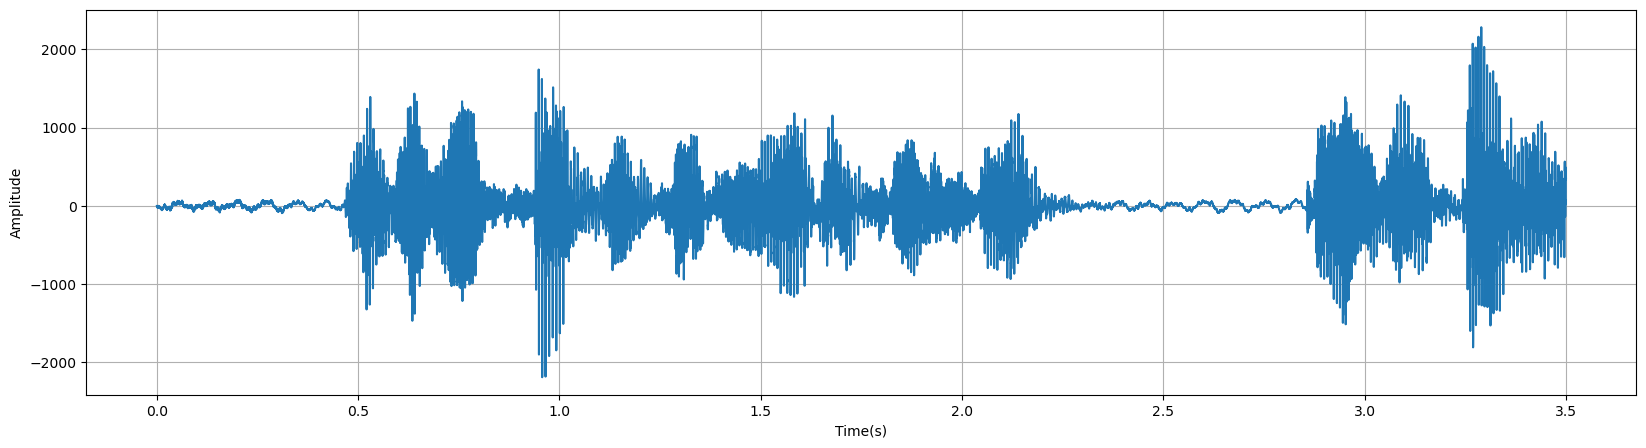

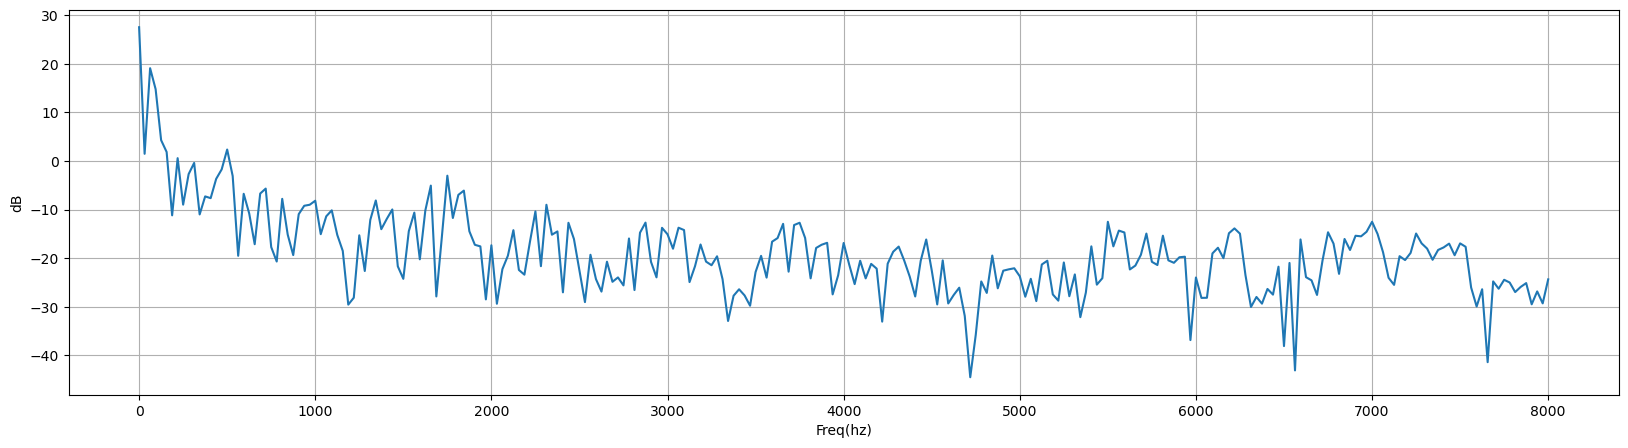

In [6]:
# signal 是音频信号，sample_rate 是采样率。fft_size 是用于离散傅里叶变换（FFT）的窗口大小。 spec 是频谱数据
sample_rate, signal = wavfile.read('./zh.wav')
# 打印采样率和信号长度的信息。
signal = signal[0: int(3.5 * sample_rate)]  # Keep the first 3.5 seconds
print('sample rate:', sample_rate, ', frame length:', len(signal))
# plot_time函数绘制时域图，显示音频信号的波形。
# plot_freq 函数绘制频域图，显示音频信号的频谱信息。
plot_time(signal, sample_rate)
plot_freq(signal, sample_rate)

In [ ]:

pre_emphasis = 0.97
emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
plot_time(emphasized_signal, sample_rate)
plot_freq(emphasized_signal, sample_rate)

In [9]:


# 定义帧的时长和帧之间的时间间隔（以秒为单位）
frame_size, frame_stride = 0.025, 0.01

# 计算帧的长度和帧之间的时间间隔（以样本点数表示）
frame_length, frame_step = int(round(frame_size * sample_rate)), int(round(frame_stride * sample_rate))

# 获取输入音频信号的长度
signal_length = len(emphasized_signal)

# 计算需要的帧数量
num_frames = int(np.ceil(np.abs(signal_length - frame_length) / frame_step)) + 1

# 计算填充后的信号长度，以确保能容纳所有帧
pad_signal_length = (num_frames - 1) * frame_step + frame_length

# 创建一个零数组，用于填充信号，以满足长度要求
z = np.zeros((pad_signal_length - signal_length))
pad_signal = np.append(emphasized_signal, z)

# 创建帧的索引矩阵
indices = np.arange(0, frame_length).reshape(1, -1) + np.arange(0, num_frames * frame_step, frame_step).reshape(-1, 1)

# 提取每个帧并存储在 frames 数组中
frames = pad_signal[indices]

# 打印帧数组的形状
print(frames.shape)


(349, 400)


In [10]:
hamming = np.hamming(frame_length)
# hamming = 0.54 - 0.46 * np.cos(2 * np.pi * np.arange(0, frame_length) / (frame_length - 1))


Text(0, 0.5, 'Amplitude')

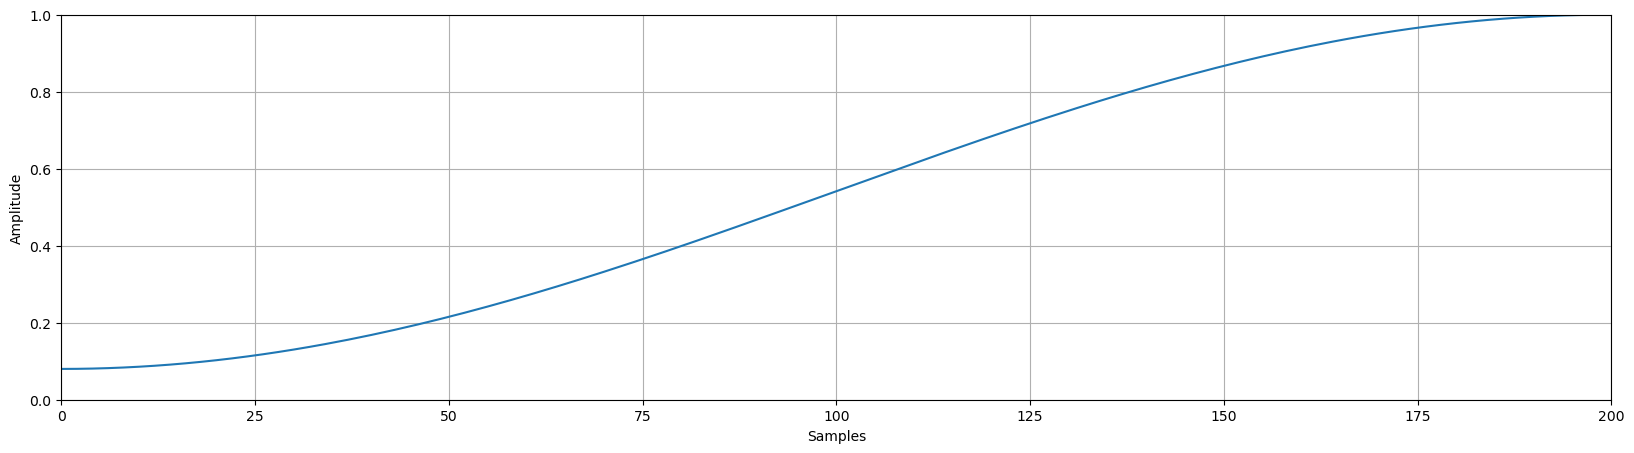

In [11]:
plt.figure(figsize=(20, 5))
plt.plot(hamming)
plt.grid()
plt.xlim(0, 200)
plt.ylim(0, 1)
plt.xlabel('Samples')
plt.ylabel('Amplitude')


In [12]:
frames *= hamming


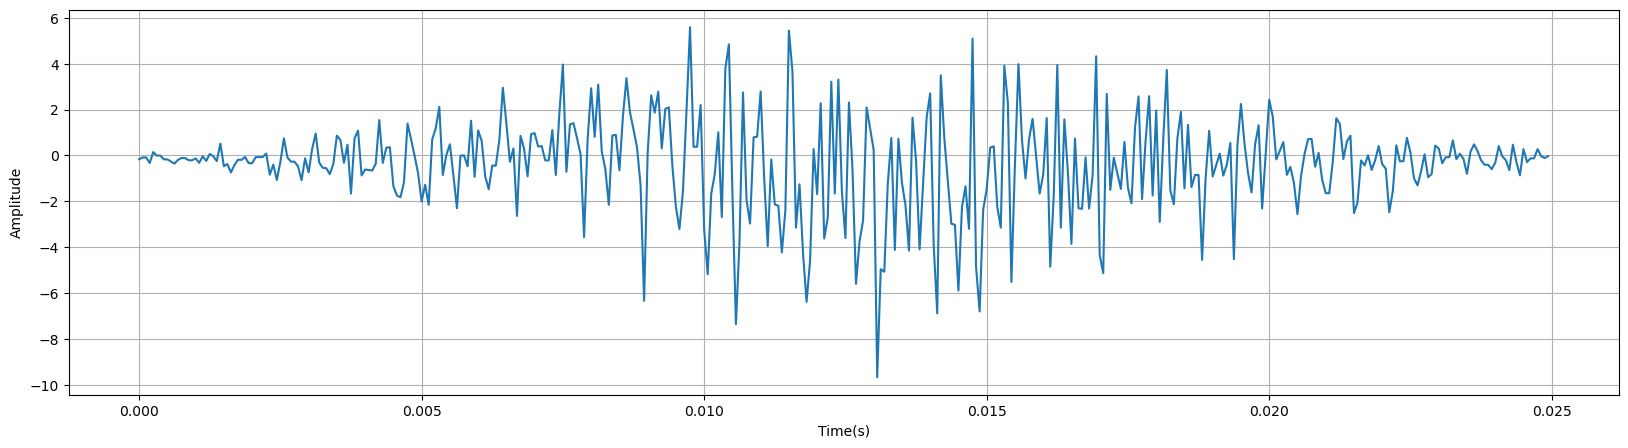

In [15]:
plot_time(frames[1], sample_rate)



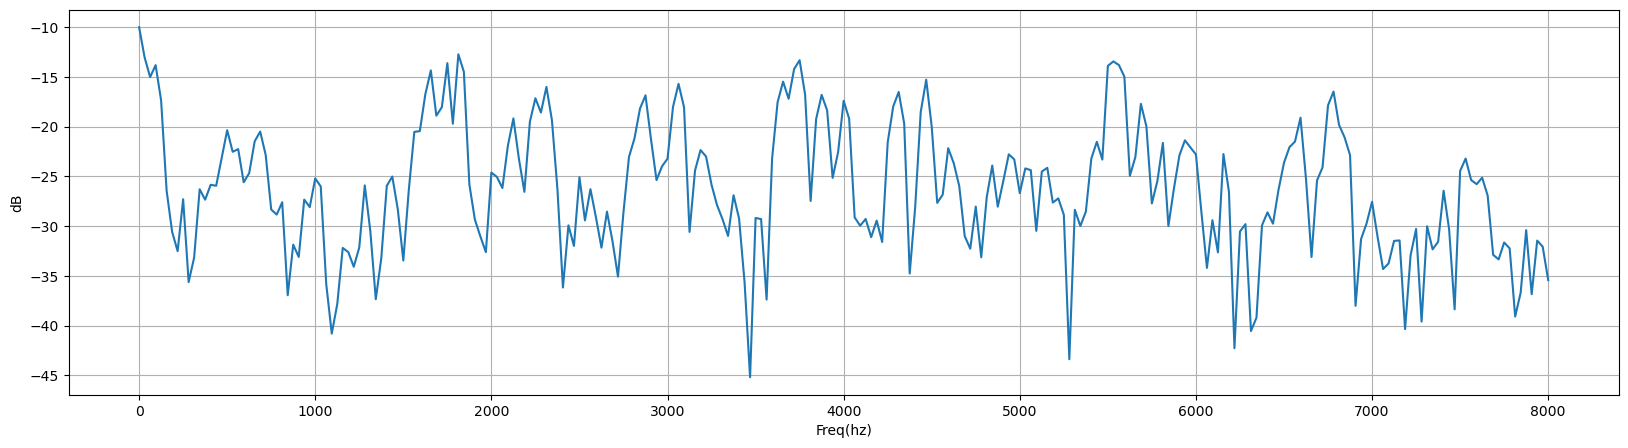

In [16]:
plot_freq(frames[1], sample_rate)

In [17]:
NFFT = 512
mag_frames = np.absolute(np.fft.rfft(frames, NFFT))
pow_frames = ((1.0 / NFFT) * (mag_frames ** 2))
print(pow_frames.shape)


(349, 257)


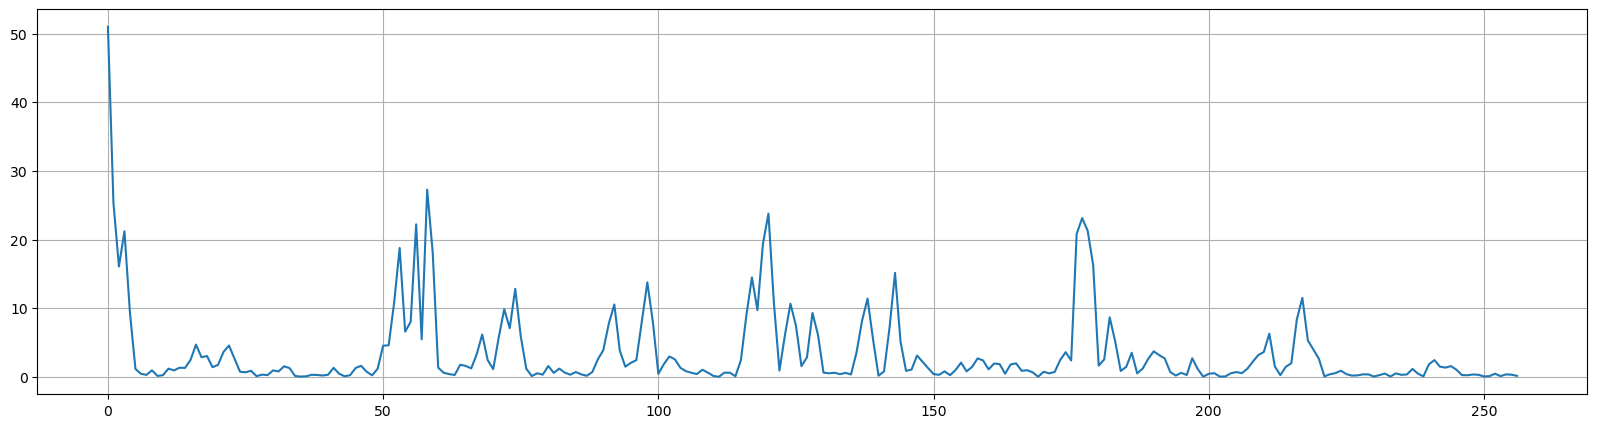

In [18]:
plt.figure(figsize=(20, 5))
plt.plot(pow_frames[1])
plt.grid()


In [19]:
low_freq_mel = 0
high_freq_mel = 2595 * np.log10(1 + (sample_rate / 2) / 700)
print(low_freq_mel, high_freq_mel)


0 2840.023046708319


In [20]:
nfilt = 40
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # 所有的mel中心点，为了方便后面计算mel滤波器组，左右两边各补一个中心点
hz_points = 700 * (10 ** (mel_points / 2595) - 1)


In [21]:
fbank = np.zeros((nfilt, int(NFFT / 2 + 1)))  # 各个mel滤波器在能量谱对应点的取值
bin = (hz_points / (sample_rate / 2)) * (NFFT / 2)  # 各个mel滤波器中心点对应FFT的区域编码，找到有值的位置
for i in range(1, nfilt + 1):
    left = int(bin[i-1])
    center = int(bin[i])
    right = int(bin[i+1])
    for j in range(left, center):
        fbank[i-1, j+1] = (j + 1 - bin[i-1]) / (bin[i] - bin[i-1])
    for j in range(center, right):
        fbank[i-1, j+1] = (bin[i+1] - (j + 1)) / (bin[i+1] - bin[i])
print(fbank)


[[0.00000000e+00 7.04240000e-01 6.15870556e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.84129444e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.20509885e-01
  6.02549425e-02 3.42509694e-15]]


In [22]:
filter_banks = np.dot(pow_frames, fbank.T)
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
filter_banks = 20 * np.log10(filter_banks)  # dB
print(filter_banks.shape)



(349, 40)


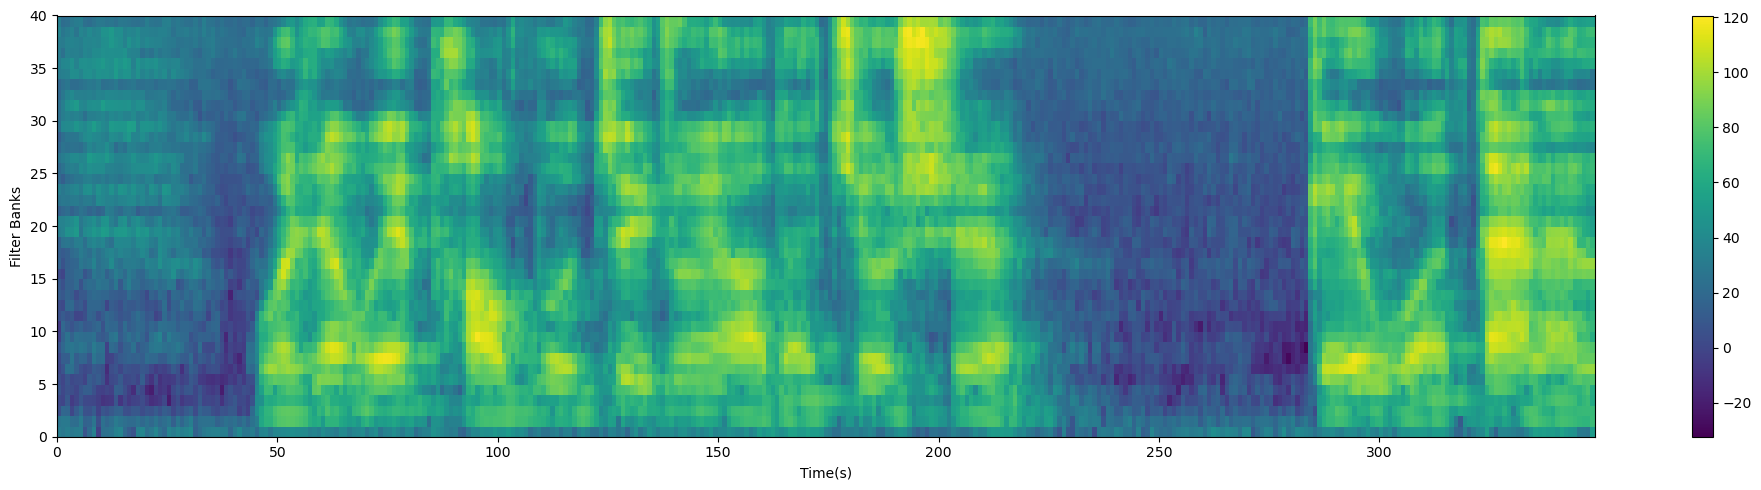

In [23]:
plot_spectrogram(filter_banks.T, 'Filter Banks')



In [24]:
# MFCC绘制
num_ceps = 12
mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1:(num_ceps+1)]
print(mfcc.shape)


(349, 12)


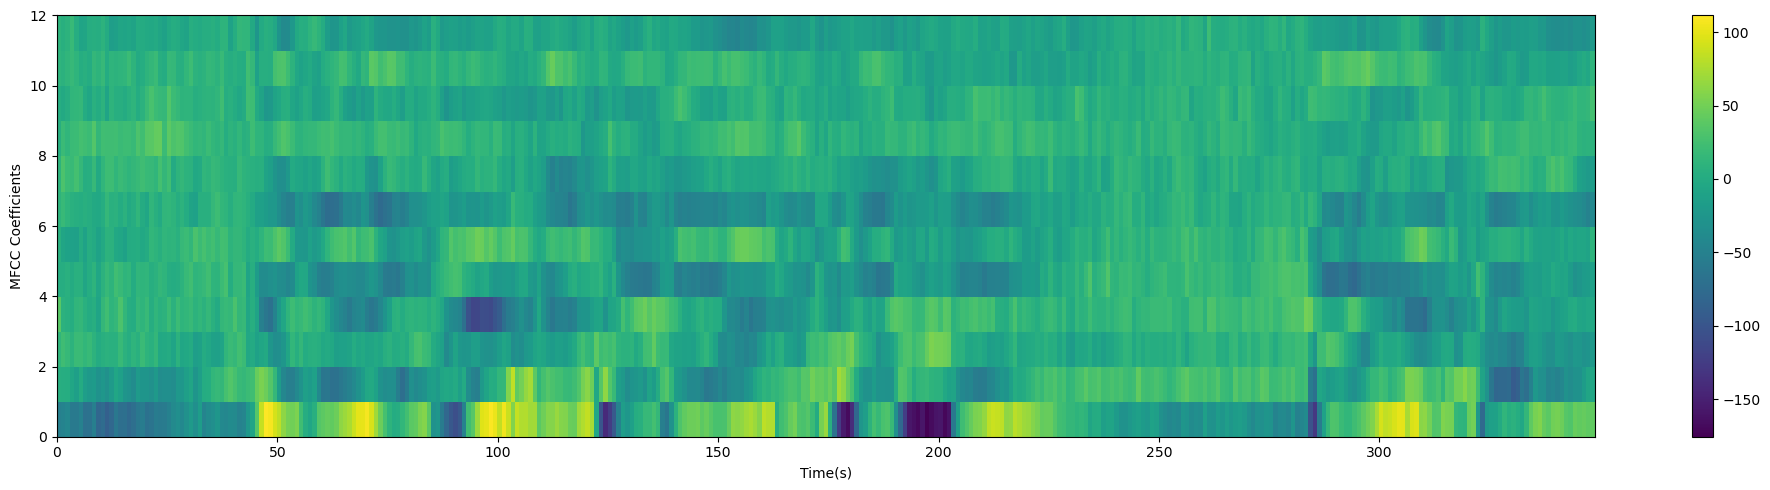

In [25]:
plot_spectrogram(mfcc.T, 'MFCC Coefficients')


In [26]:
cep_lifter = 23
(nframes, ncoeff) = mfcc.shape
n = np.arange(ncoeff)
lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
mfcc *= lift


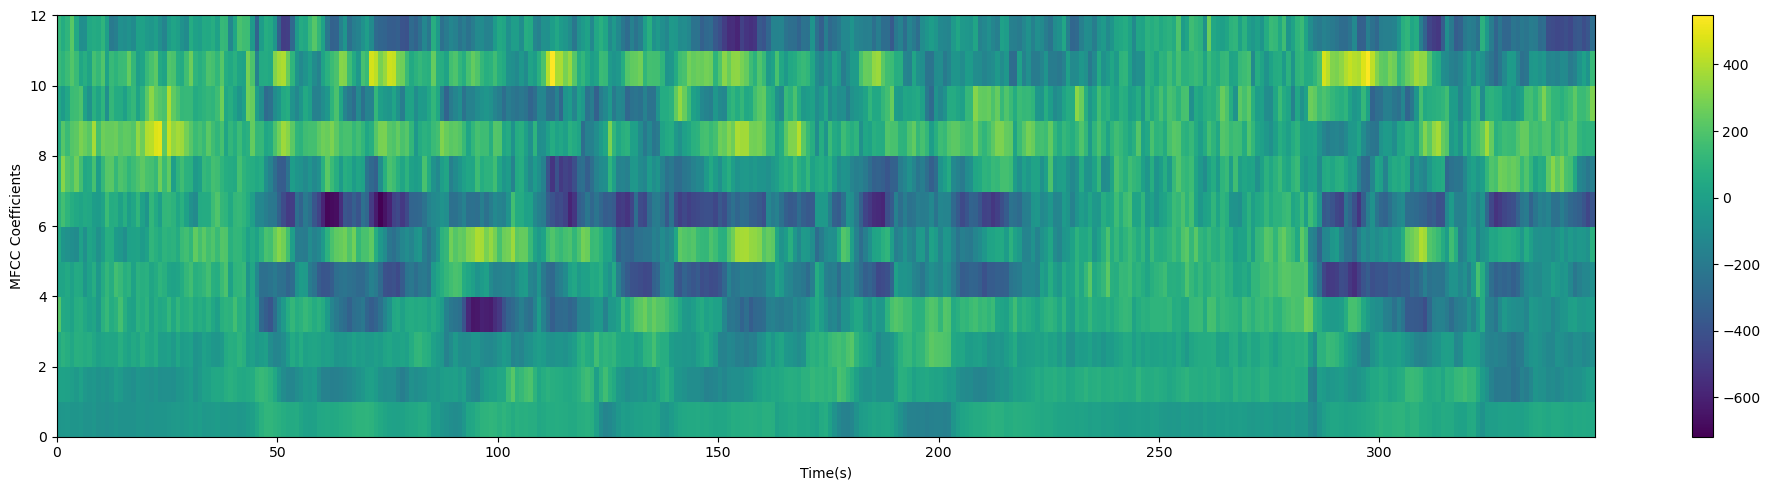

In [27]:
plot_spectrogram(mfcc.T, 'MFCC Coefficients')
